In [2]:
import shap 
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from torch.utils.data import DataLoader
import scipy
import torch_geometric as pyg 
import umap 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import gseapy as gp
import pickle as pkl 

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset

from src.interpret.extract_entity_function import extract_entity_function

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# output/gsnn/09461877-9965-4dd8-a668-97f77ef73717
model = torch.load('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/model.pt').cpu()
data = torch.load('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/Data.pt')
proc = '../output/exp4-1/proc/'

In [6]:
ids = np.array(np.load(f'{proc}/train_obs.npy', allow_pickle=True).tolist() + np.load(f'{proc}/test_obs.npy', allow_pickle=True).tolist() + np.load(f'{proc}/val_obs.npy', allow_pickle=True).tolist())

dataset = LincsDataset(proc, ids)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

X = []
sig_ids = []
for i,(x, y, sig_id) in enumerate(loader): 
    X.append(x)
    sig_ids += list(sig_id)

X = torch.cat(X, dim=0).squeeze()
X.size()

torch.Size([28052, 4988])

In [4]:
# EGFR ~ PROTEIN__P00533
# HER2 (ERBB2) ~ P04626

In [108]:
func, ex_smol, meta = extract_entity_function('PROTEIN__P04626', model, data, X)
f = lambda X: func(torch.tensor(X, dtype=torch.float)).detach().numpy()
func

dense_func_node(
  (lin1): Linear(in_features=82, out_features=5, bias=True)
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (lin3): Linear(in_features=5, out_features=41, bias=True)
  (nonlin): ELU(alpha=1.0)
)

In [109]:

# one cell line, no drug conc
exdf = pd.DataFrame(ex_smol[[0], :].expand(1000, -1), columns=meta['input_edge_names'])
exdf[[x for x in exdf.columns if 'DRUG__' in x]] = np.zeros(exdf[[x for x in exdf.columns if 'DRUG__' in x]].shape)
exdf.head()

,PROTEIN__P01135,PROTEIN__Q02297,PROTEIN__P27986,PROTEIN__Q14451,PROTEIN__P00533,PROTEIN__Q96JA1,PROTEIN__P15514,PROTEIN__P01133,PROTEIN__Q99952,PROTEIN__P51452,...,DRUG__BRD-K79930101,DRUG__BRD-K80343549,DRUG__BRD-K81528515,DRUG__BRD-K85606544,DRUG__BRD-K99964838,RNA__P04626,EXPR__P04626,METHYL__P04626,CNV__P04626,MUT__P04626
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.925728,-0.426643,-0.180563,1.882082
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.925728,-0.426643,-0.180563,1.882082
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.925728,-0.426643,-0.180563,1.882082
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.925728,-0.426643,-0.180563,1.882082
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.925728,-0.426643,-0.180563,1.882082


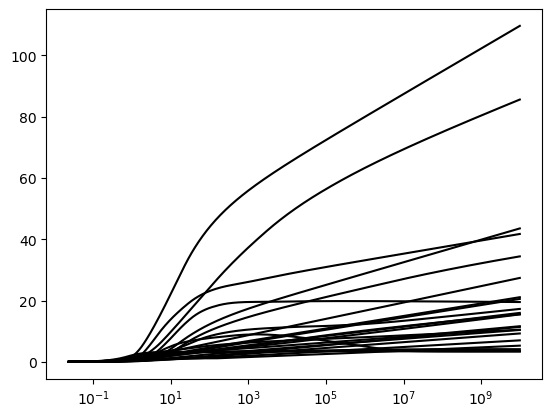

In [110]:
drugs = [x for x in exdf.columns if 'DRUG__' in x]


plt.figure()

for drug_ in drugs:  
#plt.plot(np.abs(out).mean(axis=1))
    exdf = pd.DataFrame(ex_smol[[0], :].expand(1000, -1), columns=meta['input_edge_names'])
    exdf[[x for x in exdf.columns if 'DRUG__' in x]] = np.zeros(exdf[[x for x in exdf.columns if 'DRUG__' in x]].shape)

    out_feat = 7
    exdf[drug_] = np.logspace(-2,1, 1000)

    out = f(exdf.values)
    x_conc = 10**exdf[drug_]-1
    bias = out[0, :] # initial predicted value at 0 conc 
    #plt.plot(x_conc, out[:,out_feat] - bias[out_feat], c=c)
    plt.plot(x_conc, np.abs(out - bias).mean(axis=1), c='k')# [:,out_feat], c=c)
    half_maximal_value = out[:,out_feat].min() + (out[:,out_feat].max() - out[:,out_feat].min())/2
    EC50 = x_conc[np.argmin(np.abs(out[:,out_feat] - half_maximal_value))]
    #plt.axhline(half_maximal_value)
    #plt.axvline(EC50, c=c)
plt.xscale('log')
plt.show()

In [105]:
out[0, :]

array([-4.9793444 , -0.94840544,  2.2842774 ,  2.6150324 , -0.9442446 ,
       -4.756832  ,  1.3357224 ,  0.20798469,  1.8235863 , -1.5109072 ,
       -2.1934376 ,  1.3371184 , -1.8851209 ,  2.5526416 , -0.5246808 ,
       -0.43977118, -2.99088   ,  0.36587456, -0.770801  ,  2.140738  ,
        2.3186042 ,  2.3952596 , -6.2545657 , -2.7598271 ,  2.001955  ,
       -2.6105373 ,  1.6551849 , -0.08565506, -2.1374347 ,  6.5457296 ,
        2.1993895 ,  4.703239  ,  5.166302  , -0.12064534, -1.9074547 ,
        2.3299441 , -0.8412225 ,  0.4939711 , -0.29161957,  2.2684522 ,
        5.4444485 ,  3.4310956 , -3.057044  , -4.6166377 ,  0.2438479 ,
       -3.7516944 , -1.4545794 ,  1.293331  ,  0.18366641,  1.5450265 ,
        0.64529335,  1.6151478 , -1.6164677 , -1.9526018 ,  1.6982715 ,
        1.2912631 ,  2.6042    , -1.2660973 , -3.493348  ,  1.2765441 ,
       -0.6742654 , -0.49331576, -0.9368433 , -4.9835925 ,  4.7889767 ,
        3.7057335 ,  1.5066918 , -2.4135256 ,  6.5007687 , -2.40